In [10]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Suppress annoying warnings from pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Data Cleaning

Here we map the names of the animal classes in ```class.csv``` to their corresponding ids in ```zoo.csv```.

In [18]:
animals = pd.read_csv('../data/zoo.csv')
# animals.drop(['animal_name'], axis=1, inplace=True)

classes = pd.read_csv('../data/class.csv')
classes.columns = [col.lower() for col in classes.columns]
classes = classes[['class_number', 'class_type']].rename({'class_type':'class_name', 'class_number':'class_type'}, axis=1)

animals = animals.merge(classes)

## Model Preparation

In [ ]:
targets = animals.class_name.value_counts().index
n_classes = len(targets)
features = animals.drop(['class_type', 'class_name', 'legs'], axis=1).columns

dummy_legs = pd.get_dummies(animals.legs, drop_first=True).loc[:, 1:]
dummy_legs.columns = [str(col) + '_legs'  for col in dummy_legs.columns]

animals = animals.drop('legs', 1).join(dummy_legs)
animal_names = animals.animal_name

X = animals[features].join(dummy_legs)
y = animals.class_type.as_matrix()

In [196]:
animals.columns

Index(['animal_name', 'hair', 'feathers', 'eggs', 'milk', 'airborne',
       'aquatic', 'predator', 'toothed', 'backbone', 'breathes', 'venomous',
       'fins', 'tail', 'domestic', 'catsize', 'class_type', 'class_name',
       '2_legs', '4_legs', '5_legs', '6_legs', '8_legs'],
      dtype='object')

## Define qualitative colors for plotting each class

Trying to think of some more intuitive colors for each of the classes....

In [24]:
import matplotlib.cm as cm
from matplotlib.colors import rgb2hex

cmap = cm.get_cmap('Set2', 7)
colors = [rgb2hex(cmap(i)[:3]) for i in range(7)]

# Is our data linearly separable?

## Linear Discriminant Analysis + Computational Geometry
The model will basically draw lines through the outer points of each class in lower-dimensional space to create the smallest possible polygon that encapsulates every point in the class. If any of the shapes overlap, the data is not linearly separable based on the x- and y-components. To detect overlap, we use what's called the convex hull algorithm. The picture below demonstrates this concept:


![img](../img/linear_separability_demonstration.jpg)

In [25]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
import pylab as pl

In [230]:
def plot_decomp_samples(X, y, targets, est='LDA'):
    est = est.lower()
    if est == 'lda':
        X_r = LDA(n_components=2).fit_transform(X, y)
    elif est == 'pca':
        X_r = PCA(n_components=2).fit_transform(X, y)
    else:
        raise ValueError('est must be "pca" or "lda"')
    
    plt.clf()
    fig, ax = plt.subplots(figsize = (16, 12))
    ax.tick_params(labelsize=14)
    n_classes = len(targets)

    for color, i, target in zip(colors, np.arange(1, n_classes+1), targets):
        bucket = X_r[y == i, :]
        try:
            hull = ConvexHull(bucket) 
            for j in hull.simplices:
                plt.plot(bucket[j,0], bucket[j,1], color, lw=3)
        except:
            hull = None

        coords = list(zip(bucket[:,0], bucket[:,1], animals[animals.class_type == i].index))
        plt.scatter(bucket[:, 0], bucket[:, 1], color=color, alpha=.8, lw=3, label=target)
#         for x1,x2,ind in coords:
#             pl.text(x1, x2, str(ind), color='black', fontsize=12)

    plt.legend(prop={'size': 14})
    ax.title.set_visible(False)
    fig.savefig('../img/pca_feature_selection.jpg')
    plt.show()

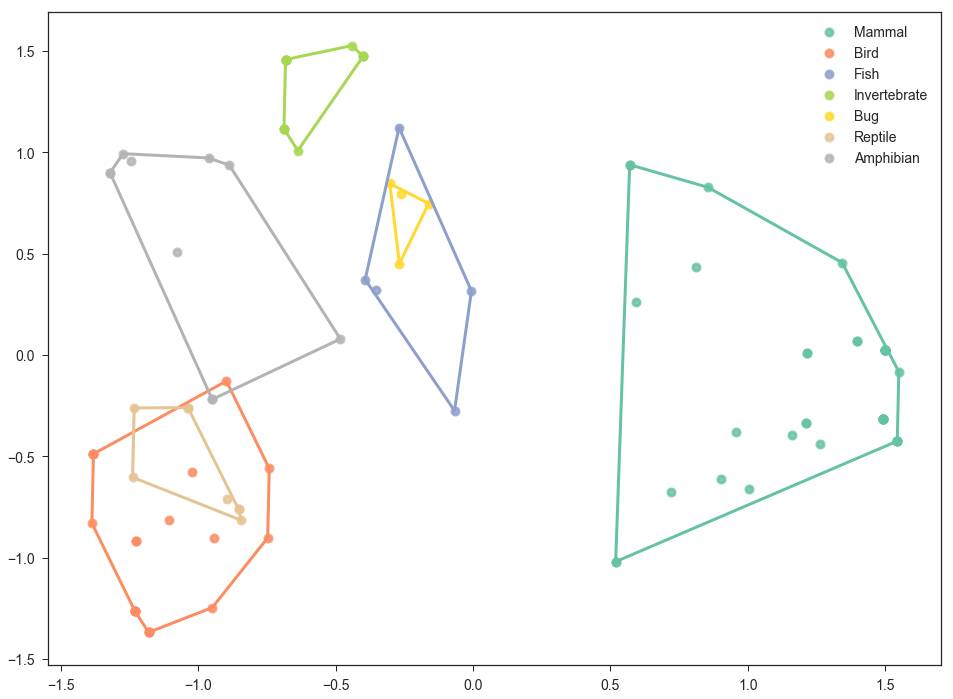

In [231]:
sns.set_style('ticks')
plot_decomp_samples(X.drop('animal_name', 1), y, targets, 'pca')

# SVM Hyperparameter Tuning

Now that we know the dataset is linearly separable, let's cross-validate the model to find the optimal hyperparameters. Although we performed perfectly on all of the data with a linear kernel, other kernels might generalize better, so the hyperparameters of interest will be **C**, **gamma**, and **kernel**.

In [146]:
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split

n_simulations = 1000
best_params_arr = []
for seed in range(n_simulations):
    X_train, X_test, y_train, y_test = train_test_split(X.drop('animal_name', 1), y, stratify=y, random_state=seed) 

    Cs = [.001, .01, .1, 1, 10]
    gammas = [.001, .01, .1, 1]
    kernels = ['linear', 'rbf', 'poly', 'sigmoid']

    param_grid = {'C':Cs, 'gamma':gammas, 'kernel':kernels}

    n_folds = n_classes # Number of folds must be less than number of obs in smallest class
    grid_search = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3, scoring='f1_weighted')
    grid_search.fit(X_train, y_train)
    best_params_arr.append(grid_search.best_params_)

In [150]:
pd.DataFrame(best_params_arr).groupby(['kernel','C', 'gamma']).size().reset_index(name='Count')

,kernel,C,gamma,Count
0,linear,0.100,0.001,157
1,linear,1.000,0.001,165
2,poly,0.001,1.000,22
3,poly,0.010,1.000,212
4,poly,0.100,1.000,136
5,rbf,1.000,0.100,217
6,rbf,10.000,0.010,41
7,rbf,10.000,0.100,13
8,sigmoid,1.000,0.100,25
9,sigmoid,10.000,0.010,2


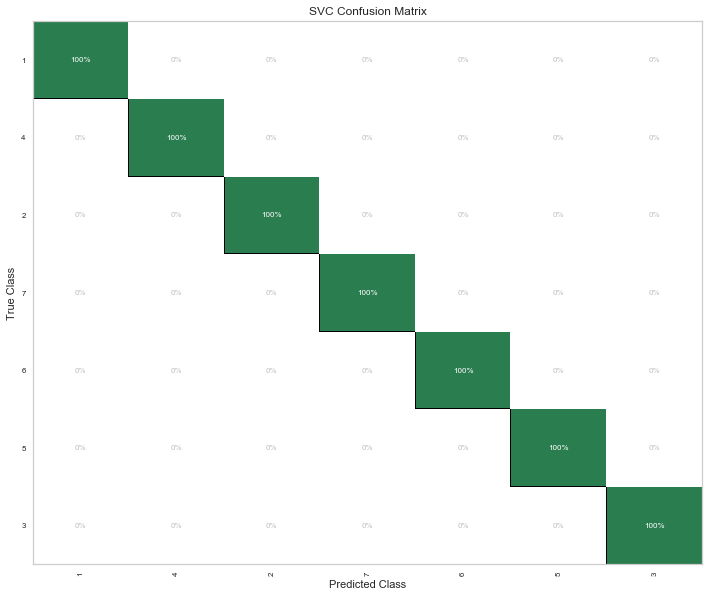

In [154]:
from yellowbrick.classifier import ConfusionMatrix
svc = SVC(kernel='linear', C=1, gamma=.001)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

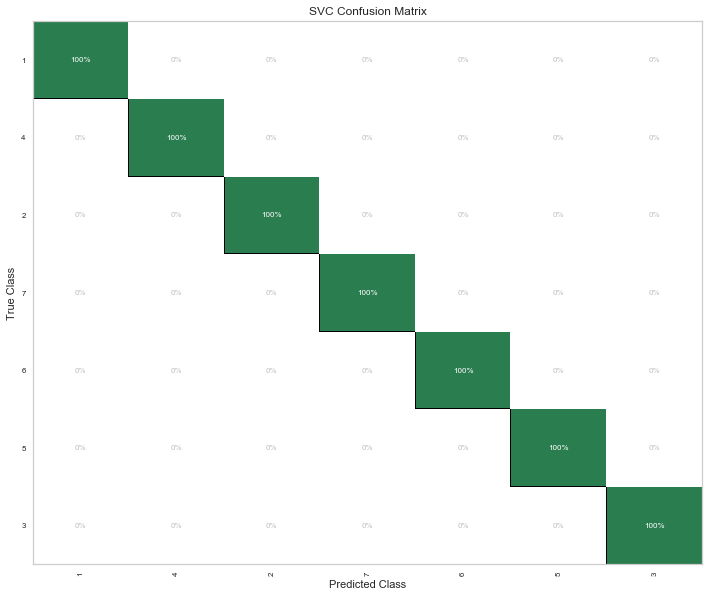

In [155]:
svc = SVC(kernel='poly', C=.01, gamma=1)

plt.figure(figsize=(12, 10))
cm = ConfusionMatrix(svc, classes=animals.class_type.unique())
cm.fit(X.drop('animal_name', 1), y).score(X.drop('animal_name', 1), y)
fig = cm.poof()

# Testing

Let's see if we just got lucky with our cross-validation by simulating a variety of random seeds for splitting the data into test and train.

In [240]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_fscore_support

def test_model(seed, X, y, est):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=seed)
    if est == 'poly_svc':
        params = {'C': .01, 'gamma': 1, 'kernel': 'poly', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'linear_svc':
        params = {'C': 1, 'kernel': 'linear', 'class_weight': 'balanced'}
        model = SVC(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    elif est == 'knc':
        params = {'metric': 'jaccard', 'n_neighbors': 3, 'weights': 'distance'}
        model = KNeighborsClassifier(**params).fit(X_train.drop(['animal_name'], axis=1), y_train)
    else:
        raise ValueError('est parameter must be linear_svc or poly_svc')
        
    for animal_name,actual,pred in zip(X_train.animal_name, y_test, model.predict(X_test.drop(['animal_name'], axis=1))):
        if actual != pred:
            bad.append((est, animal_name))
    
    y_preds = model.predict(X_test.drop(['animal_name'], axis=1))
    accuracy = model.score(X_test.drop(['animal_name'], axis=1), y_test)
    f1 = f1_score(y_test, y_preds, average='weighted')
    
    return accuracy, f1, pd.DataFrame(list(precision_recall_fscore_support(y_test, y_preds))).transpose().as_matrix()

In [241]:
def simulate_model(n_simulations, X, y, est):
    scores = []
    f1_scores = []
    accuracies = []
    for seed in range(n_simulations):
#         if seed % 100 == 0: print(seed)
        accuracy, f1, scoring = test_model(seed, X, y, est.lower())
        scores.append(scoring)
        accuracies.append(accuracy)
        f1_scores.append(f1)
#     print('The average accuracy for ' + est.upper() + ' across {} simulations was {:.2%}'.format(n_simulations, np.mean(scores)))
    return np.mean(accuracies), np.mean(f1_scores), scores

In [242]:
estimators = ['poly_svc', 'linear_svc', 'knc']

In [243]:
bad = []
n_simulations = 1000
scores = []
accuracies = []
f1_scores = []
for est in estimators:
    accuracy, f1, scoring = simulate_model(n_simulations, X, y, est)
    scores.append(scoring)
    accuracies.append((est, accuracy))
    f1_scores.append((est, f1))

In [244]:
average_scores = []
for score,est in list(zip(scores,estimators)):
    total = score[0]
    for i in range(1, n_simulations):
        total = total + score[i]
    df = pd.DataFrame(total / n_simulations)
    df.columns = ['precision', 'recall', 'fscore', 'support']
    df['model'] = est
    average_scores.append(classes.join(df).drop('class_type', 1).set_index('class_name'))

In [173]:
accuracies

[('poly_svc', 0.96473076923076928),
 ('linear_svc', 0.96253846153846168),
 ('knc', 0.96534615384615396)]

In [195]:
f1_scores

[('poly_svc', 0.95490723443223458),
 ('linear_svc', 0.95548543956043963),
 ('knc', 0.95935629370629361)]

In [174]:
average_scores = pd.concat(average_scores).reset_index()

In [176]:
fscores = average_scores[['model', 'class_name', 'fscore']]
fscores = fscores.pivot(index='model', columns='class_name', values='fscore').reset_index()
fscores.model = ['Support Vector Machine (Polynomial Kernel)', 'Support Vector Machine (Linear Kernel)', 'K Neighbors Classifier']

In [188]:
fscores = average_scores[['model', 'class_name', 'fscore']]
fscores = fscores.pivot(index='model', columns='class_name', values='fscore').reset_index()
fscores.model = ['K Neighbors Classifier', 'Support Vector Machine (Linear Kernel)', 'Support Vector Machine (Polynomial Kernel)']

In [189]:
categories

['Amphibian', 'Bird', 'Bug', 'Fish', 'Invertebrate', 'Mammal', 'Reptile']

K Neighbors Classifier
[1.0, 1.0, 0.8473333333333296, 1.0, 0.8852619047619087, 0.9953999999999994, 0.5455, 1.0]
Support Vector Machine (Linear Kernel)
[0.9963333333333332, 1.0, 0.9796666666666658, 0.9683809523809542, 0.9077999999999953, 0.9995, 0.7059999999999984, 0.9963333333333332]
Support Vector Machine (Polynomial Kernel)
[0.8556666666666664, 1.0, 0.9234761904761892, 0.9695714285714305, 0.8986714285714259, 0.9995238095238096, 0.691999999999998, 0.8556666666666664]


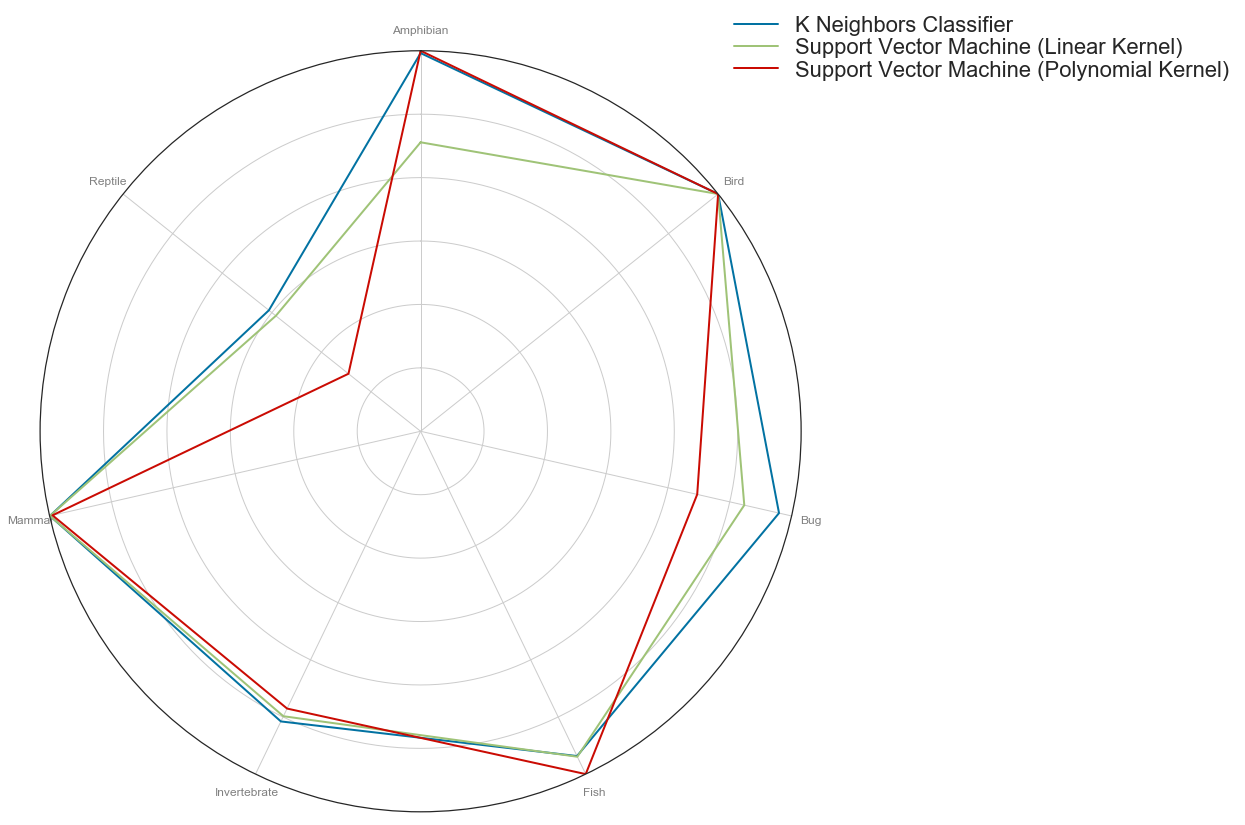

In [226]:
from math import pi


# number of variable
categories = list(fscores)[1:]
N = len(categories)

# Angle calcs
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Value calcs
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='polar')

plt.xticks(angles[:-1], categories, color='grey', size=12)
ax.title.set_visible(False)

# Put the first axis on top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.40, .50, .60, .70, .80, .90], ["", "", "", "", "", ""], color="grey", size=7)
plt.ylim(0.4,1)

for model,color in list(zip(fscores.model, ['r', 'b', 'g'])):
    print(model)
    print(values)
    values = fscores[fscores.model == model].drop('model', 1).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid')

ax.legend(fscores.model.values, loc=(0.9, .95), labelspacing=0.1, fontsize=22)
# # Add a title
plt.title('Model F-scores by Class', size=18, color='black', y=1.1)
# fig.savefig('../img/model_comparison_fscores_all.jpg')

## Jackknife Cross-Validation

Since our dataset is so small, we will try leave-one-out cross-validation. This can be thought of as k-fold cross-validation where k=n.

In [249]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import LeaveOneOut

In [250]:
wrong_dfs = []

In [276]:
def jackknife_cv(X, y, est='SVC', ts=False):
    est = est.lower()
    if est == 'poly_svc':
        params = {'C': .01, 'gamma': 1, 'kernel': 'poly', 'class_weight': 'balanced'}
        model = SVC(**params)
    elif est == 'linear_svc':
        params = {'C': 1, 'kernel': 'linear', 'class_weight': 'balanced'}
        model = SVC(**params)
    elif est == 'knc':
        params = {'metric': 'jaccard', 'n_neighbors': 3, 'weights': 'distance'}
        model = KNeighborsClassifier(**params)
    else:
        raise ValueError('est parameter must be poly_svc, linear_svc, or knc')
    
    scores = []
    wrong_index = []
    wrong_pred = []
    for train_index, test_index in LeaveOneOut().split(X.drop('animal_name', 1)):
        X_train, X_test = X.drop('animal_name', 1).loc[train_index], X.drop('animal_name', 1).loc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        if not ts:
            if y_test[0] != model.predict(X_test)[0]:
                wrong_index.append(test_index[0])
                wrong_pred.append(model.predict(X_test)[0])
    return scores, wrong_index, wrong_pred

In [283]:
classes

,class_type,class_name
0,1,Mammal
1,2,Bird
2,3,Reptile
3,4,Fish
4,5,Amphibian
5,6,Bug
6,7,Invertebrate


In [284]:
wrong_dfs = []
for est in estimators:
    scores, wrong_index, wrong_pred = jackknife_cv(X, y, est)
    print('The average accuracy for ' + est.upper() + ' with jackknife cross-validation was {:.2%}.'.format(np.mean(scores)))
    wrong_dfs.append((est, animal_names.iloc[wrong_index], wrong_pred))

The average accuracy for POLY_SVC with jackknife cross-validation was 97.03%.
The average accuracy for LINEAR_SVC with jackknife cross-validation was 97.03%.
The average accuracy for KNC with jackknife cross-validation was 97.03%.


## Which samples are difficult to predict?

In [285]:
for est,df,wr in wrong_dfs:
    print(est)
    print(df)
    print(wr)

poly_svc
94        newt
97    seasnake
99    tortoise
Name: animal_name, dtype: object
[3, 7, 7]
linear_svc
79    scorpion
94        newt
97    seasnake
Name: animal_name, dtype: object
[3, 3, 4]
knc
79    scorpion
97    seasnake
99    tortoise
Name: animal_name, dtype: object
[3, 4, 2]


In [288]:
classes

,class_type,class_name
0,1,Mammal
1,2,Bird
2,3,Reptile
3,4,Fish
4,5,Amphibian
5,6,Bug
6,7,Invertebrate


In [292]:
animals[animals.animal_name == 'tortoise']

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,tail,domestic,catsize,class_type,class_name,2_legs,4_legs,5_legs,6_legs,8_legs
99,tortoise,0,0,1,0,0,0,0,0,1,...,1,0,1,3,Reptile,0,1,0,0,0


In [254]:
dfs = [df.reset_index() for _, df in wrong_dfs]

In [ ]:
wrong = pd.concat(dfs)

### Incorrect Predictionsl

In [259]:
wrong.groupby('animal_name').apply(lambda x: x.shape[0])

animal_name
newt        2
scorpion    2
seasnake    3
tortoise    2
dtype: int64

# Feature Selection

Let's see if we can remove some redundant features and make our model more generalizable. 

## Linear SVM

In [324]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC

params = {'C': 1, 'kernel': 'linear', 'class_weight': 'balanced'}
svc = SVC(**params)
selector = RFECV(svc, step=1, cv=StratifiedKFold(3))
selector = selector.fit(X.drop('animal_name', 1), y)

In [325]:
important_features = pd.Series(X.drop('animal_name', 1).columns)[selector.support_]

In [326]:
important_features[19] = 'animal_name' # Add back in so for ease of use with previously defined functions

In [327]:
important_features

1        feathers
2            eggs
3            milk
5         aquatic
7         toothed
8        backbone
9        breathes
11           fins
15         2_legs
16         4_legs
18         6_legs
19    animal_name
dtype: object

# Modeling After Feature Selection

In [202]:
estimators = ['poly_svc', 'linear_svc', 'knc']

In [203]:
bad = []
n_simulations = 1000
scores = []
accuracies = []
f1_scores = []
for est in estimators:
    accuracy, f1, scoring = simulate_model(n_simulations, X[important_features], y, est)
    scores.append(scoring)
    accuracies.append((est, accuracy))
    f1_scores.append((est, f1))

In [204]:
average_scores = []
for score,est in list(zip(scores,estimators)):
    total = score[0]
    for i in range(1, n_simulations):
        total = total + score[i]
    df = pd.DataFrame(total / n_simulations)
    df.columns = ['precision', 'recall', 'fscore', 'support']
    df['model'] = est
    average_scores.append(classes.join(df).drop('class_type', 1).set_index('class_name'))

In [205]:
accuracies

[('poly_svc', 0.96346153846153859),
 ('linear_svc', 0.96800000000000008),
 ('knc', 0.97503846153846163)]

In [206]:
f1_scores

[('poly_svc', 0.95559047619047632),
 ('linear_svc', 0.96131190476190476),
 ('knc', 0.97248882783882784)]

In [207]:
average_scores = pd.concat(average_scores).reset_index()

In [208]:
fscores = average_scores[['model', 'class_name', 'fscore']]
fscores = fscores.pivot(index='model', columns='class_name', values='fscore').reset_index()
fscores.model = ['Support Vector Machine (Polynomial Kernel)', 'Support Vector Machine (Linear Kernel)', 'K Neighbors Classifier']

In [209]:
fscores = average_scores[['model', 'class_name', 'fscore']]
fscores = fscores.pivot(index='model', columns='class_name', values='fscore').reset_index()
fscores.model = ['K Neighbors Classifier', 'Support Vector Machine (Linear Kernel)', 'Support Vector Machine (Polynomial Kernel)']

In [210]:
categories

['Amphibian', 'Bird', 'Bug', 'Fish', 'Invertebrate', 'Mammal', 'Reptile']

K Neighbors Classifier
[1.0, 1.0, 0.8473333333333296, 1.0, 0.8852619047619087, 0.9953999999999994, 0.5455, 1.0]
Support Vector Machine (Linear Kernel)
[0.9963333333333332, 1.0, 0.9796666666666658, 0.9683809523809542, 0.9077999999999953, 0.9995, 0.7059999999999984, 0.9963333333333332]
Support Vector Machine (Polynomial Kernel)
[0.8556666666666664, 1.0, 0.9234761904761892, 0.9695714285714305, 0.8986714285714259, 0.9995238095238096, 0.691999999999998, 0.8556666666666664]


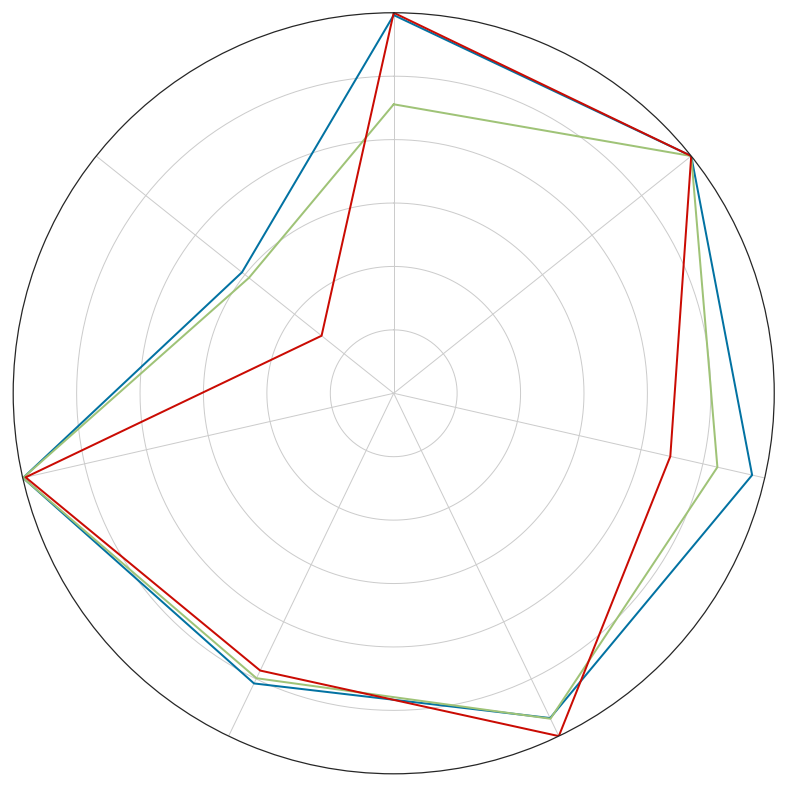

In [227]:
from math import pi


# number of variable
categories = list(fscores)[1:]
N = len(categories)

# Angle calcs
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Value calcs
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111, projection='polar')

plt.xticks(angles[:-1], ["", "", "", "", "", "", ""], color='grey', size=12)
ax.title.set_visible(False)

# Put the first axis on top
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([0.40, .50, .60, .70, .80, .90], ["", "", "", "", "", ""], color="grey", size=7)
plt.ylim(0.4,1)

for model,color in list(zip(fscores.model, ['r', 'b', 'g'])):
    print(model)
    print(values)
    values = fscores[fscores.model == model].drop('model', 1).values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid')

# ax.legend(fscores.model.values, loc=(0.9, .95), labelspacing=0.1, fontsize=22)
# # Add a title
plt.title('Model F-scores by Class', size=18, color='black', y=1.1)
fig.savefig('../img/model_comparison_fscores_feature_selection.jpg')

## Which samples are difficult to predict?

In [300]:
wrong_dfs = []
for est in estimators:
    scores, wrong_index, wrong_pred = jackknife_cv(X[important_features], y, est)
    print('The average accuracy for ' + est.upper() + ' with jackknife cross-validation was {:.2%}.'.format(np.mean(scores)))
    wrong_dfs.append((est, animal_names.loc[wrong_index], wrong_pred))

The average accuracy for POLY_SVC with jackknife cross-validation was 98.02%.
The average accuracy for LINEAR_SVC with jackknife cross-validation was 98.02%.
The average accuracy for KNC with jackknife cross-validation was 96.04%.


In [301]:
for est,df,wr in wrong_dfs:
    print(est)
    print(df)
    print(wr)

poly_svc
97    seasnake
99    tortoise
Name: animal_name, dtype: object
[7, 7]
linear_svc
26    platypus
97    seasnake
Name: animal_name, dtype: object
[5, 4]
knc
26     platypus
97     seasnake
99     tortoise
100     tuatara
Name: animal_name, dtype: object
[5, 4, 5, 5]


In [305]:
dfs = [df.reset_index() for _, df in wrong_dfs]

AttributeError: 'list' object has no attribute 'reset_index'

In [268]:
wrong = pd.concat(dfs)

### Incorrect Predictionsl

In [269]:
wrong.groupby('animal_name').apply(lambda x: x.shape[0])

animal_name
platypus    2
seasnake    3
tortoise    2
tuatara     1
dtype: int64

## Seasnake Exploration

In [306]:
animals[animals.class_name == 'Reptile']

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,tail,domestic,catsize,class_type,class_name,2_legs,4_legs,5_legs,6_legs,8_legs
96,pitviper,0,0,1,0,0,0,1,1,1,...,1,0,0,3,Reptile,0,0,0,0,0
97,seasnake,0,0,0,0,0,1,1,1,1,...,1,0,0,3,Reptile,0,0,0,0,0
98,slowworm,0,0,1,0,0,0,1,1,1,...,1,0,0,3,Reptile,0,0,0,0,0
99,tortoise,0,0,1,0,0,0,0,0,1,...,1,0,1,3,Reptile,0,1,0,0,0
100,tuatara,0,0,1,0,0,0,1,1,1,...,1,0,0,3,Reptile,0,1,0,0,0


In [307]:
from sklearn.metrics import jaccard_similarity_score

In [ ]:
seasnake = animals.drop(['animal_name', 'class_name', 'class_type'], 1).loc[97]

In [322]:
animals[(animals['2_legs'] == 0) & (animals['4_legs'] == 0) & (animals['5_legs'] == 0) & (animals['6_legs'] == 0) & (animals['8_legs'] == 0) & (animals['tail'] == 1)]

,animal_name,hair,feathers,eggs,milk,airborne,aquatic,predator,toothed,backbone,...,tail,domestic,catsize,class_type,class_name,2_legs,4_legs,5_legs,6_legs,8_legs
9,dolphin,0,0,0,1,0,1,1,1,1,...,1,0,1,1,Mammal,0,0,0,0,0
29,porpoise,0,0,0,1,0,1,1,1,1,...,1,0,1,1,Mammal,0,0,0,0,0
41,bass,0,0,1,0,0,1,1,1,1,...,1,0,0,4,Fish,0,0,0,0,0
42,carp,0,0,1,0,0,1,0,1,1,...,1,1,0,4,Fish,0,0,0,0,0
43,catfish,0,0,1,0,0,1,1,1,1,...,1,0,0,4,Fish,0,0,0,0,0
44,chub,0,0,1,0,0,1,1,1,1,...,1,0,0,4,Fish,0,0,0,0,0
45,dogfish,0,0,1,0,0,1,1,1,1,...,1,0,1,4,Fish,0,0,0,0,0
46,haddock,0,0,1,0,0,1,0,1,1,...,1,0,0,4,Fish,0,0,0,0,0
47,herring,0,0,1,0,0,1,1,1,1,...,1,0,0,4,Fish,0,0,0,0,0
48,pike,0,0,1,0,0,1,1,1,1,...,1,0,1,4,Fish,0,0,0,0,0


In [ ]:
jac_score_arrs = []
for i, reptile_i in animals.drop(['animal_name', 'class_name', 'class_type'], 1).loc[96:101].iterrows():
    jac_scores = []
    for j, reptile_j in animals.drop(['animal_name', 'class_name', 'class_type'], 1).loc[96:101].iterrows():
        jac_scores.append(jaccard_similarity_score(reptile_i, reptile_j))
    jac_score_arrs.append(jac_scores)

In [319]:
pd.DataFrame(jac_score_arrs, index=np.arange(96, 101), columns=np.arange(96, 101).astype(str))

,96,97,98,99,100
96,1.00,0.85,0.95,0.75,0.90
97,0.85,1.00,0.80,0.60,0.75
98,0.95,0.80,1.00,0.80,0.95
99,0.75,0.60,0.80,1.00,0.85
100,0.90,0.75,0.95,0.85,1.00


## PCA After Feature Selection

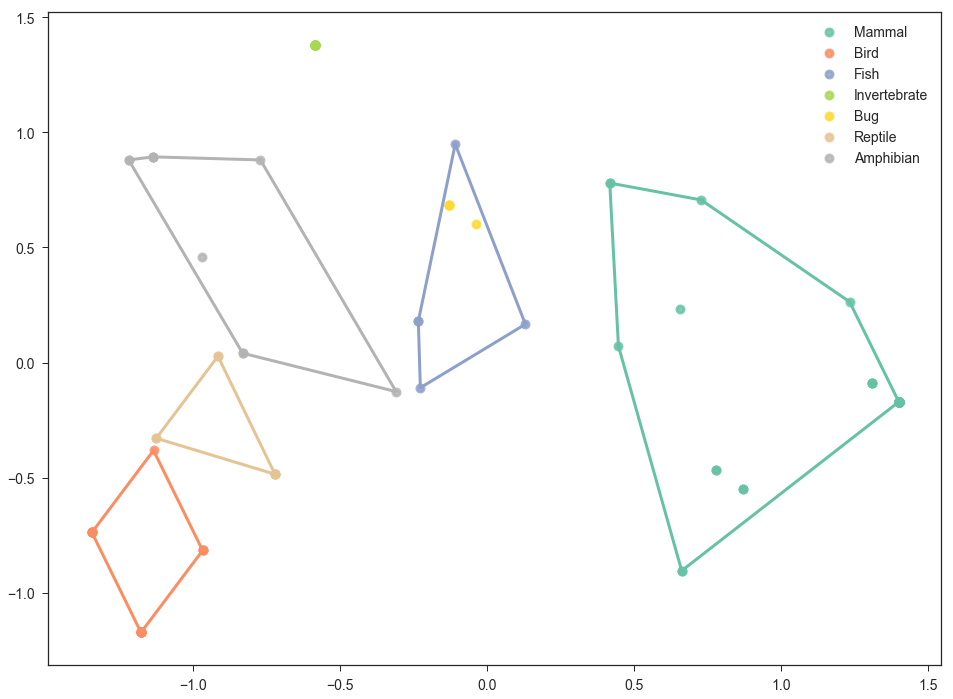

In [229]:
sns.set_style('ticks')
plot_decomp_samples(X[important_features[:-1]], y, targets, 'pca')

In [42]:
bad_df = pd.DataFrame(bad, columns=['model', 'animal_name'])
bad_df = bad_df.merge(pd.DataFrame(animal_names), how='left')

In [43]:
animal_counts = pd.DataFrame(bad_df.groupby('model').animal_name.value_counts())
animal_counts.columns = ['cnt']
animal_counts = animal_counts.reset_index()
animal_counts = animal_counts.merge(animal_names)

animal_counts = animal_counts.sort_values(['model', 'cnt'], ascending=False)

,model,animal_name,cnt,class_name
11,svc,dove,17,Bird
23,svc,mongoose,15,Mammal
243,svc,ostrich,12,Bird
283,svc,lion,12,Mammal
59,svc,bass,11,Fish
95,svc,girl,11,Mammal
15,svc,hamster,10,Mammal
19,svc,flea,10,Bug
39,svc,oryx,10,Mammal
63,svc,pike,10,Fish


In [44]:
class_counts = pd.DataFrame(animal_names.groupby(['class_name']).count()).reset_index()
animal_counts = animal_counts.merge(class_counts, on='class_name', how='left', suffixes=('_animal', '_class'))

In [46]:
animal_counts.groupby('animal_name_animal').cnt.sum().sort_values(ascending=False).head(5)

animal_name_animal
dove        71
mongoose    65
flea        60
gnat        60
oryx        57
Name: cnt, dtype: int64

Let's try a support vector machine with only the import features....

In [153]:
for est,df in wrong_dfs:
    print(est)
    print(df)

svc
   animal_name class_name
97    seasnake    Reptile
99    tortoise    Reptile


In [82]:
bad = []
n_simulations = 10000
copy = important_features.copy()
copy = np.append(copy, 'animal_name')
for est in estimators:
    scores = simulate_model(n_simulations, X[copy], y, est)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
The average accuracy for SVC across 10000 simulations was 97.78%
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100

## Target Shuffling

In [99]:
n_simulations = 1000
shuffled_scores = []
for sim in range(1, n_simulations+1):
    if sim % 100 == 0: print(sim)
    np.random.shuffle(y)
    scores, _ = jackknife_cv(X[important_features], y, 'svc', ts=True)
    shuffled_scores.append(np.mean(scores))

100
200
300
400
500
600
700
800
900
1000


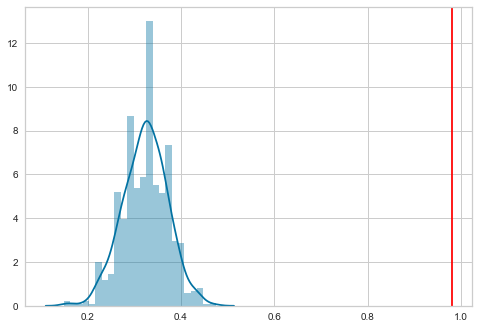

In [105]:
sns.distplot(shuffled_scores)
plt.axvline(0.98, color='red')

After target shuffling, it's blatantly obvious that our results were not random in any sense of the word.